In [2]:
# Notebook initialization for consistent paths (repo-aware)
import os, sys, pathlib

# Resolve repo root by walking up until we find 'src'
CWD = pathlib.Path.cwd()
ROOT = CWD
for _ in range(6):
    if (ROOT / 'src').exists():
        break
    ROOT = ROOT.parent
# Fallback to current if not found
if not (ROOT / 'src').exists():
    ROOT = CWD

PROJECT_ROOT = ROOT.resolve()
PROJECT_SRC = PROJECT_ROOT / 'src'
DATA_DIR = PROJECT_SRC / 'data'
RAW_DATA_DIR = DATA_DIR / 'raw'
PROCESSED_DATA_DIR = DATA_DIR / 'processed'
RAW_DATA_DIR.mkdir(parents=True, exist_ok=True)
PROCESSED_DATA_DIR.mkdir(parents=True, exist_ok=True)

if str(PROJECT_SRC) not in sys.path:
    sys.path.insert(0, str(PROJECT_SRC))

print(f'PROJECT_ROOT={PROJECT_ROOT}')
print(f'PROJECT_SRC={PROJECT_SRC}')
print(f'RAW_DATA_DIR={RAW_DATA_DIR}')
print(f'PROCESSED_DATA_DIR={PROCESSED_DATA_DIR}')


PROJECT_ROOT=/Users/pierce.bucknerwolfso/Desktop/embeddings_paper/embeddings-service-exploration
PROJECT_SRC=/Users/pierce.bucknerwolfso/Desktop/embeddings_paper/embeddings-service-exploration/src
RAW_DATA_DIR=/Users/pierce.bucknerwolfso/Desktop/embeddings_paper/embeddings-service-exploration/src/data/raw
PROCESSED_DATA_DIR=/Users/pierce.bucknerwolfso/Desktop/embeddings_paper/embeddings-service-exploration/src/data/processed


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_curve, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import torch
import warnings
import gc   
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import xgboost as xgb
import joblib


device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')
torch.manual_seed(42)

In [4]:
X = df.drop('loan_outcome', axis=1)
y = df['loan_outcome']

Numeric columns: ['avg_cur_bal', 'dti', 'fico_range_high', 'int_rate', 'loan_amnt', 'mort_acc', 'num_op_rev_tl', 'revol_util']
Categorical columns: ['addr_state', 'earliest_cr_line', 'emp_length', 'emp_title', 'sub_grade', 'title', 'zip_code']
Encoded shapes: (876521, 258574) (219131, 258574) (273913, 258574)
scale_pos_weight: 3.7092124279397622

--- Training XGBoost (raw features baseline) ---
[0]	validation_0-logloss:0.68976
[50]	validation_0-logloss:0.62595
[100]	validation_0-logloss:0.62126
[150]	validation_0-logloss:0.61978
[200]	validation_0-logloss:0.61867
[250]	validation_0-logloss:0.61792
[300]	validation_0-logloss:0.61724
[350]	validation_0-logloss:0.61679
[400]	validation_0-logloss:0.61633
[450]	validation_0-logloss:0.61586
[500]	validation_0-logloss:0.61546
[550]	validation_0-logloss:0.61515
[600]	validation_0-logloss:0.61474
[650]	validation_0-logloss:0.61446
[700]	validation_0-logloss:0.61416
[750]	validation_0-logloss:0.61395
[800]	validation_0-logloss:0.61367
[850]	vali

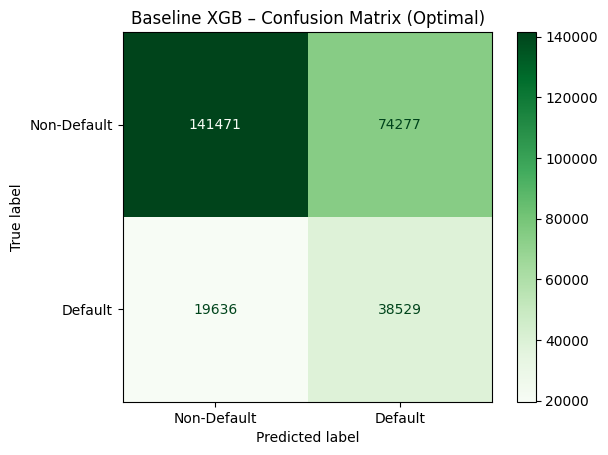


=== Baseline XGB (0.5 threshold) ===
              precision    recall  f1-score   support

           0       0.88      0.65      0.75    215748
           1       0.34      0.67      0.45     58165

    accuracy                           0.65    273913
   macro avg       0.61      0.66      0.60    273913
weighted avg       0.76      0.65      0.68    273913

ROC AUC: 0.718396742960773


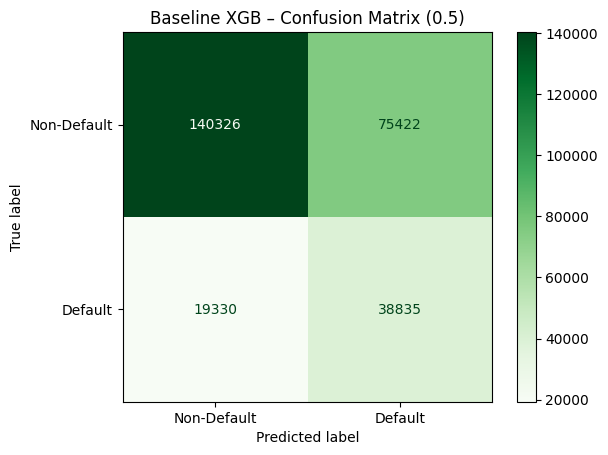

4575

In [ ]:
# === Baseline preprocessing for raw features (no embeddings) ===
# 1) Parse/clean raw columns
# 2) Split train/val/test
# 3) Fit ColumnTransformer (OHE for categorical, scale numeric)
# 4) Train XGBoost with early stopping

# Load
CSV_PATH = f"{PROCESSED_DATA_DIR}/final_features_for_embeddings.csv"
df = pd.read_csv(CSV_PATH)

# Target and features
y = df['loan_outcome'].astype(np.int8)
X = df.drop(columns=['loan_outcome']).copy()

# Basic cleaning helpers
num_like_as_object = ['avg_cur_bal', 'dti', 'mort_acc', 'num_op_rev_tl', 'revol_util']

# Strip non-numeric, coerce to float
for col in num_like_as_object:
    if col in X.columns:
        X[col] = (
            X[col]
            .astype(str)
            .str.replace(r"[^0-9.\-]", "", regex=True)
            .replace({"": np.nan, "-": np.nan})
            .astype(float)
        )

# Zip_code: ensure string (treat as categorical bucket)
if 'zip_code' in X.columns:
    X['zip_code'] = X['zip_code'].astype(str)

# Identify dtypes after cleaning
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)

# Split BEFORE fitting transformers to avoid leakage
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.20, stratify=y_temp, random_state=42
)

# ColumnTransformer: scale numeric, OHE categorical
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(with_mean=False), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse=True), cat_cols),
    ],
    sparse_threshold=1.0,  # keep sparse to save memory
)

# Fit on train only
X_train_enc = preprocessor.fit_transform(X_train)
X_val_enc   = preprocessor.transform(X_val)
X_test_enc  = preprocessor.transform(X_test)

print("Encoded shapes:", X_train_enc.shape, X_val_enc.shape, X_test_enc.shape)

# Class imbalance handling
neg, pos = (y_train == 0).sum(), (y_train == 1).sum()
scale_pos_weight = float(neg / max(1, pos))
print("scale_pos_weight:", scale_pos_weight)

# XGBoost config
xgb_clf = xgb.XGBClassifier(
    objective="binary:logistic",
    n_estimators=10000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.0,
    tree_method="gpu_hist",
    random_state=42,
    # n_jobs=-1,
    scale_pos_weight=scale_pos_weight,
    eval_metric="logloss",
)

print("\n--- Training XGBoost (raw features baseline) ---")
xgb_clf.fit(
    X_train_enc, y_train,
    eval_set=[(X_val_enc, y_val)],
    verbose=50,
    early_stopping_rounds=50,
)

# Persist artifacts for reuse
joblib.dump(preprocessor, "baseline_preprocessor.joblib")
xgb_clf.save_model("baseline_xgb_raw.json")

# Evaluate
y_prob = xgb_clf.predict_proba(X_test_enc)[:, 1]
prec, rec, thr = precision_recall_curve(y_test, y_prob)
f1s = 2 * (prec * rec) / (prec + rec + 1e-9)
idx = np.argmax(f1s[:-1])
best_thr = thr[idx]
print(f"Best Threshold: {best_thr:.4f}")

for name, pred in {
    "Optimal": (y_prob >= best_thr).astype(int),
    "0.5": (y_prob >= 0.5).astype(int),
}.items():
    print(f"\n=== Baseline XGB ({name} threshold) ===")
    print(classification_report(y_test, pred))
    print("ROC AUC:", roc_auc_score(y_test, y_prob))
    cm = confusion_matrix(y_test, pred, labels=[0,1])
    ConfusionMatrixDisplay(cm, display_labels=["Non-Default","Default"]).plot(cmap="Greens", values_format="d")
    plt.title(f"Baseline XGB – Confusion Matrix ({name})")
    plt.show()

# Free memory
del X_train_enc, X_val_enc, X_test_enc
gc.collect()
